# Mix EMA & Couple candlesticks & Momentum - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

remote


In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [6]:
def get_ema_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low'] and r['diff_cema'] < 12.5 and r['max_3xupper_wick'] < 1.65:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low'] and -9.5 < r['diff_cema'] and -2.55 < r['min_3xlower_shadow'] < 0.5:
        signal = 'short'
    return signal

In [7]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short' and r['RSI'] < 65.5 and -7.5 < r['price_move']:
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long' and r['RSI'] > 29.5 and -1.5 < r['price_move'] < 6.5:
        signal = 'long'
    return signal

In [8]:
def cal_signal(row):
    signal = ''
    if not row['first_close']:
        return signal
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65 and row['ADX'] < 26.5:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39 and row['ADX'] < 26.5:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

def cal_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1355]
    if not tick.empty:
        return tick[0]
        
def get_day_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['_2pm_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_2pm_price': cal_price,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['day_Close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    return day_data[['prev_day_Close', 'first_close', 'prev_high', 'prev_low']]

def add_momentum_signal(data):
    clone_data = data.copy()
    day_data = get_day_data(clone_data)
    clone_data = clone_data.assign(time_d=pd.PeriodIndex(clone_data.index, freq='1D').to_timestamp())
    df_merged = pd.merge(clone_data, day_data, left_on="time_d", right_index=True, how="left")
    # df_merged = clone_data.merge(day_data, how='left', left_index=True, right_index=True)
    df_merged['mom_y'] = df_merged.apply(lambda r: 100 * (r['Close'] - r['prev_day_Close']) / r['prev_day_Close'] if r['first_close'] else 0, axis=1)
    df_merged['body_rate'] = df_merged.apply(lambda r: (r['Close'] - r['first_close']) / (r['prev_high'] - r['prev_low']) if r['first_close'] else 0, axis=1)
    df_merged['momentum_signal'] = df_merged.apply(lambda r: cal_signal(r), axis=1)
    df_merged.loc[100 * df_merged.index.hour + df_merged.index.minute != 1355, 'momentum_signal'] = ''
    return df_merged
    

In [9]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    # Optimnize
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 42)
    data = data.assign(ADX=adx['ADX_42'])
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data['Close_s1'] = data['Close'].shift(1)
    data['price_move'] = data.apply(lambda r: (r['Close'] - r['Close_s1']) - 0.5 * r['ATR_14'] , axis=1)
    data["body_size"] = abs(data["Close"] - data["Open"])
    data['upper_wick'] = data.apply(lambda r: r['High'] - max(r['Close'], r['Open']), axis=1)
    data['_3xupper_wick'] = data.apply(lambda r: r['upper_wick'] * r['upper_wick'] * r['upper_wick'] - r['body_size'], axis=1)
    data['max_3xupper_wick'] = data['_3xupper_wick'].rolling(3).max()
    data['max_3upper_wick'] = data['upper_wick'].rolling(3).max()
    data['max_3upper_wick'] = round(data['max_3upper_wick'], 1)
    data['sum_3upper_wick'] = data['upper_wick'].rolling(3).sum()
    data['sum_3upper_wick'] = round(data['sum_3upper_wick'], 1)
    data['lower_shadow'] = data.apply(lambda r: min(r['Close'], r['Open']) - r['Low'], axis=1)
    data['_3xlower_shadow'] = data.apply(lambda r: r['lower_shadow'] * r['lower_shadow'] * r['lower_shadow'] - r['body_size'], axis=1)
    data['min_3xlower_shadow'] = data['_3xlower_shadow'].rolling(3).min()
    data['max_3lower_shadow'] = data['lower_shadow'].rolling(3).max()
    data['max_3lower_shadow'] = round(data['max_3lower_shadow'], 1)
    data['sum_3lower_shadow'] = data['lower_shadow'].rolling(3).sum()
    data['sum_3lower_shadow'] = round(data['sum_3lower_shadow'], 1)
    data['ibs'] = data.apply(lambda x: (0 if (x["High"] == x["Low"]) else round((x["Close"] - x["Low"]) / (x["High"] - x["Low"]), 1)), axis=1)
    data['sum_3ibs'] = data['ibs'].rolling(3).sum()
    data['sum_3ibs'] = round(data['sum_3ibs'], 1)
    # EMA signal
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['diff_cema'] = data['Close'] - data['ema_low']
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['ema_signal'] = data.apply(lambda r: get_ema_signal(r), axis=1)
    # Couple candlesticks signal
    data['low_s1'] = data['Low'].shift(1)
    data['high_s1'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)
    # Momentum signal
    data = add_momentum_signal(data)    
    return data

In [10]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [11]:
prepared_data = prepare_data(data)
prepared_data.dropna(subset=['Close'],inplace=True)

In [12]:
prepared_data

,Open,High,Low,Close,Volume,current,ADX,RSI,ATR_14,Close_s1,...,condition_2,couple_cs_signal,time_d,prev_day_Close,first_close,prev_high,prev_low,mom_y,body_rate,momentum_signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910,2020-11-02 09:05:00,NaN,NaN,NaN,NaN,...,,,2020-11-02,NaN,898.6,901.5,895.4,NaN,0.245902,
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670,2020-11-02 09:10:00,NaN,NaN,NaN,900.1,...,,,2020-11-02,NaN,898.6,901.5,895.4,NaN,0.131148,
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329,2020-11-02 09:15:00,NaN,NaN,NaN,899.4,...,,,2020-11-02,NaN,898.6,901.5,895.4,NaN,0.147541,
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722,2020-11-02 09:20:00,NaN,NaN,NaN,899.5,...,,,2020-11-02,NaN,898.6,901.5,895.4,NaN,0.000000,
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939,2020-11-02 09:25:00,NaN,NaN,NaN,898.6,...,,,2020-11-02,NaN,898.6,901.5,895.4,NaN,-0.065574,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141,2025-02-14 14:20:00,20.218629,37.097272,1.580743,1343.1,...,,,2025-02-14,1337.5,1348.3,1350.4,1341.1,0.284112,-0.752688,
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593,2025-02-14 14:25:00,19.759080,37.668846,1.567833,1341.3,...,,,2025-02-14,1337.5,1348.3,1350.4,1341.1,0.291589,-0.741935,
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207,2025-02-14 14:30:00,19.319337,43.726244,1.584416,1341.4,...,long,long,2025-02-14,1337.5,1348.3,1350.4,1341.1,0.373832,-0.623656,


In [13]:
backtest_data = prepared_data[['Open', 'Close', 'High', 'Low', 'min_in_range', 'max_in_range', 'min_5', 'max_5', 'ema_signal', 'momentum_signal', 'couple_cs_signal', 'RSI', 'ema_low', 'ema_fast']]
backtest_data[(backtest_data.ema_signal != '') | (backtest_data.momentum_signal != '') | (backtest_data.couple_cs_signal != '')]

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal,RSI,ema_low,ema_fast
Date,,,,,,,,,,,,,,
2020-11-02 14:25:00,904.9,907.0,907.0,904.5,896.6,907.0,896.6,907.0,,,long,68.216746,NaN,900.274541
2020-11-03 09:20:00,908.5,908.1,908.8,908.1,897.4,909.4,908.1,909.4,,,short,64.301187,NaN,904.089555
2020-11-04 09:35:00,907.8,907.3,908.0,907.3,907.3,909.9,907.3,908.8,,,short,47.205851,NaN,907.875361
2020-11-04 10:05:00,908.2,909.0,909.0,908.1,906.7,909.0,906.8,909.0,,,long,57.591408,NaN,907.988330
2020-11-04 10:15:00,910.2,911.5,911.5,909.8,906.7,911.5,907.6,911.5,,,long,68.726453,NaN,908.496116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 14:25:00,1335.7,1332.8,1335.8,1332.8,1332.8,1339.8,1332.8,1338.0,,,short,20.430799,1335.114614,1337.478862
2025-02-13 09:10:00,1331.3,1330.8,1331.7,1330.5,1329.5,1338.0,1329.5,1333.0,short,,,26.633798,1334.957820,1334.956624
2025-02-13 10:40:00,1328.7,1329.8,1329.8,1328.6,1326.2,1331.2,1326.2,1329.8,,,long,45.732198,1334.174495,1329.784352


In [14]:
backtest_data[backtest_data.momentum_signal != '']

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal,RSI,ema_low,ema_fast
Date,,,,,,,,,,,,,,
2020-11-04 13:55:00,912.8,916.3,917.2,912.5,912.1,917.2,912.4,917.2,,long,,66.296297,NaN,913.054180
2020-11-06 13:55:00,908.3,907.3,908.4,906.7,903.3,908.6,903.5,908.6,,short,,48.557803,NaN,907.050340
2020-11-11 13:55:00,914.3,915.6,915.7,914.0,914.0,921.2,914.0,921.0,,short,,33.870686,918.634290,919.244944
2020-11-13 13:55:00,931.6,932.9,933.4,931.2,929.2,933.4,929.2,933.4,,long,,72.912131,922.902318,930.334917
2020-11-16 13:55:00,928.2,933.5,933.8,928.2,925.5,936.3,925.5,934.0,,short,,52.238208,926.941473,932.110829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-09 13:55:00,1314.7,1313.1,1314.9,1313.1,1313.1,1317.3,1313.1,1317.2,,short,short,33.683325,1324.264740,1315.929677
2025-01-10 13:55:00,1307.2,1309.3,1309.3,1306.2,1305.2,1310.4,1305.2,1309.3,,short,,45.525926,1320.242233,1309.382785
2025-01-17 13:55:00,1312.9,1315.4,1316.7,1312.8,1309.6,1316.7,1310.8,1316.7,,long,,74.301638,1304.258688,1311.608437


In [15]:
backtest_data

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal,RSI,ema_low,ema_fast
Date,,,,,,,,,,,,,,
2020-11-02 09:00:00,900.1,900.1,900.2,899.3,NaN,NaN,NaN,NaN,,,,NaN,NaN,NaN
2020-11-02 09:05:00,900.2,899.4,900.2,898.7,NaN,NaN,NaN,NaN,,,,NaN,NaN,NaN
2020-11-02 09:10:00,899.5,899.5,900.0,899.0,NaN,NaN,NaN,NaN,,,,NaN,NaN,NaN
2020-11-02 09:15:00,899.4,898.6,899.5,898.2,NaN,NaN,NaN,NaN,,,,NaN,NaN,NaN
2020-11-02 09:20:00,898.5,898.2,898.6,896.5,NaN,NaN,896.5,900.2,,,,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1341.3,1343.0,1340.3,1340.3,1344.2,1340.3,1344.2,,,,37.097272,1337.889347,1343.885390
2025-02-14 14:20:00,1340.9,1341.4,1341.9,1340.5,1340.3,1344.2,1340.3,1344.2,,,,37.668846,1337.917321,1343.648686
2025-02-14 14:25:00,1341.1,1342.5,1342.5,1340.7,1340.3,1344.2,1340.3,1344.2,,,long,43.726244,1337.953836,1343.539287


In [40]:
class MainStrategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 29
    #
    momentum_trailing_sl = 5.5
    momentum_tp_step = 29
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 29
    #
    def init(self):
        self._broker._cash = 1500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        _time = self.data.index
        current_time = _time[-1]
        # Close deal at 14:30
        if current_time.hour == 14 and current_time.minute >= 25:
            ema_fast = self.data.ema_fast[-1]
            ema_low = self.data.ema_low[-1]
            if self.strategy == 'couple_cs' or self.strategy == 'momentum':
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
            elif self.strategy == 'ema':
                if self.position.is_long and ema_fast < ema_low:
                    self.strategy = ''
                    self.position.close()
                elif self.position.is_short and ema_fast > ema_low:
                    self.strategy = ''
                    self.position.close()
            # Do nothing after 14h30
            return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
        else:
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # limit_price = close_price - 2
                # self.buy(size=2, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                # limit_price = close_price + 2
                # self.sell(size=1, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # limit_price = close_price - 2
                # self.buy(size=2, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                # limit_price = close_price + 2
                # self.sell(size=1, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # limit_price = close_price - 2
                # self.buy(size=2, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                # limit_price = close_price + 2
                # self.sell(size=1, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'couple_cs'

In [41]:
bt = Backtest(backtest_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [42]:
stats

Start                     2020-11-02 09:00:00
End                       2025-02-14 14:45:00
Duration                   1565 days 05:45:00
Exposure Time [%]                   45.589369
Equity Final [$]                   3134.28836
Equity Peak [$]                    3151.19349
Return [%]                         108.952557
Buy & Hold Return [%]               49.072325
Return (Ann.) [%]                   18.972402
Volatility (Ann.) [%]                7.471886
Sharpe Ratio                         2.539172
Sortino Ratio                        6.574958
Calmar Ratio                         6.334674
Max. Drawdown [%]                   -2.995008
Avg. Drawdown [%]                   -0.281104
Max. Drawdown Duration      116 days 03:05:00
Avg. Drawdown Duration        2 days 19:09:00
# Trades                                 1403
Win Rate [%]                        39.272986
Best Trade [%]                       3.327168
Worst Trade [%]                     -0.762228
Avg. Trade [%]                    

In [19]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1383,1,53480,53485,1292.38760,1288.5,-3.88760,-0.003008,2025-01-13 10:30:00,2025-01-13 10:55:00,None,0 days 00:25:00
1384,1,53504,53511,1295.18844,1298.0,2.81156,0.002171,2025-01-13 13:55:00,2025-01-13 14:30:00,None,0 days 00:35:00
1385,-1,53516,53562,1295.01138,1290.2,4.81138,0.003715,2025-01-14 09:15:00,2025-01-14 14:30:00,None,0 days 05:15:00
1386,1,53621,53636,1308.19234,1304.2,-3.99234,-0.003052,2025-01-16 09:30:00,2025-01-16 10:45:00,None,0 days 01:15:00
1387,-1,53649,53666,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00
1388,1,53670,53788,1309.49273,1324.8,15.30727,0.011689,2025-01-17 09:20:00,2025-01-21 10:40:00,None,4 days 01:20:00
1389,-1,53811,53817,1318.70427,1321.3,-2.59573,-0.001968,2025-01-21 14:00:00,2025-01-21 14:30:00,None,0 days 00:30:00
1390,1,53874,53919,1324.69729,1342.9,18.20271,0.013741,2025-01-23 09:20:00,2025-01-23 14:30:00,None,0 days 05:10:00
1391,1,53942,53970,1340.60206,1342.1,1.49794,0.001117,2025-01-24 10:45:00,2025-01-24 14:30:00,None,0 days 03:45:00
1392,1,53992,54014,1319.89585,1316.1,-3.79585,-0.002876,2025-02-03 10:40:00,2025-02-03 13:55:00,None,0 days 03:15:00


In [20]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [21]:
trades = stats['_trades']

In [22]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

261.2528800000134

In [23]:
trades[(trades.EntryTime > '2023-01-01 00:00:00') & (trades.EntryTime < '2024-01-01 00:00:00')]['PnL'].sum()

442.2136200000083

In [24]:
trades[(trades.EntryTime > '2022-01-01 00:00:00') & (trades.EntryTime < '2023-01-01 00:00:00')]['PnL'].sum()

591.8109700000126

In [25]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1,-1,110,117,907.02781,910.8,-3.77219,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,0 days 00:35:00
6,-1,432,454,923.52286,927.1,-3.57714,-0.003873,2020-11-12 11:00:00,2020-11-12 14:15:00,None,0 days 03:15:00
10,-1,640,656,935.71920,939.6,-3.88080,-0.004147,2020-11-18 11:30:00,2020-11-18 14:15:00,None,0 days 02:45:00
12,-1,720,749,946.91584,950.6,-3.68416,-0.003891,2020-11-20 09:40:00,2020-11-20 13:30:00,None,0 days 03:50:00
14,1,833,845,962.28860,958.2,-4.08860,-0.004249,2020-11-24 10:35:00,2020-11-24 13:00:00,None,0 days 02:25:00
...,...,...,...,...,...,...,...,...,...,...,...
1392,1,53992,54014,1319.89585,1316.1,-3.79585,-0.002876,2025-02-03 10:40:00,2025-02-03 13:55:00,None,0 days 03:15:00
1394,-1,54031,54035,1321.50343,1325.3,-3.79657,-0.002873,2025-02-04 09:40:00,2025-02-04 10:00:00,None,0 days 00:20:00
1395,-1,54044,54048,1321.90331,1325.8,-3.89669,-0.002948,2025-02-04 10:45:00,2025-02-04 11:05:00,None,0 days 00:20:00
1399,1,54315,54324,1332.79972,1329.0,-3.79972,-0.002851,2025-02-11 13:30:00,2025-02-11 14:15:00,None,0 days 00:45:00


In [26]:
trades[trades.PnL < -3.1]['PnL'].sum()

-2795.2050399999725

In [27]:
len(trades[trades.PnL < -3.1]) * -3.1

-2216.5

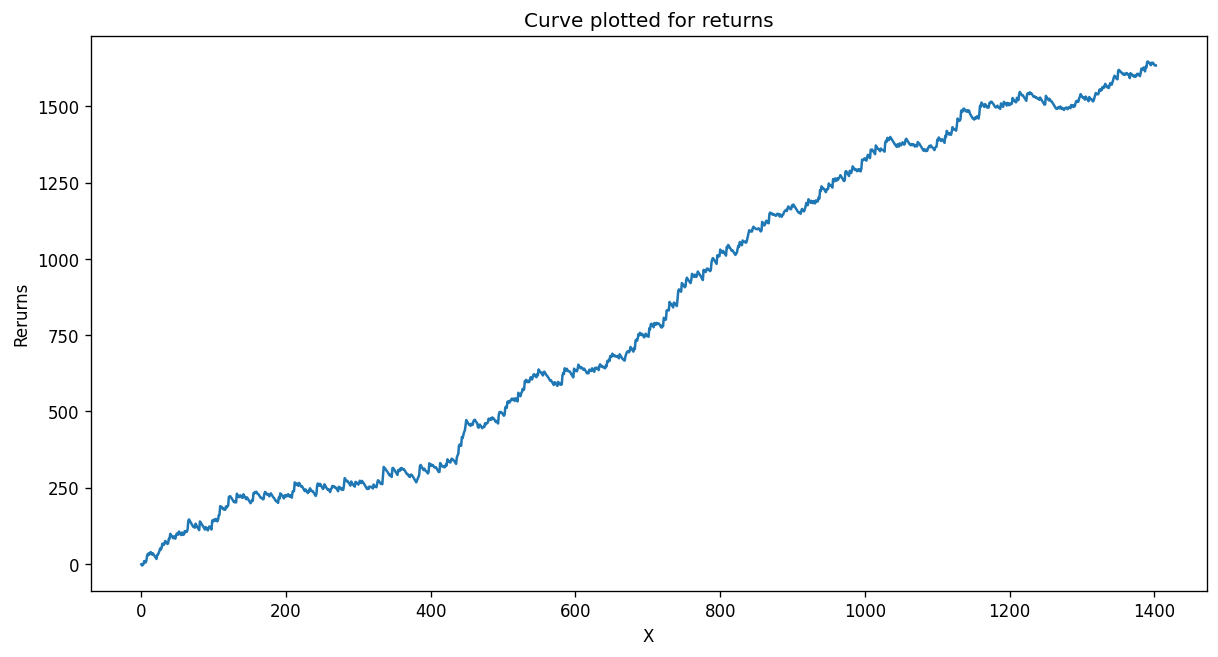

In [28]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [29]:
trades[trades.EntryTime > '2024-06-03 00:00:00']['PnL'].sum()

131.27319000000807

In [30]:
trades[(trades.EntryTime > '2024-12-13 00:00:00') & (trades.EntryTime < '2024-12-16 23:00:00')]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1359,-1,52456,52466,1331.90031,1335.8,-3.89969,-0.002928,2024-12-13 09:25:00,2024-12-13 10:15:00,None,0 days 00:50:00
1360,-1,52514,52551,1336.39896,1336.0,0.39896,0.000299,2024-12-16 10:00:00,2024-12-16 14:30:00,None,0 days 04:30:00


In [31]:
trades['PnL'].sum()

1634.2883600000514

In [32]:
class Main2Strategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 27
    #
    momentum_trailing_sl = 4.5
    momentum_tp_step = 27
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 27
    #
    def init(self):
        self._broker._cash = 1500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        _time = self.data.index
        current_time = _time[-1]
        # Close deal at 14:30
        if current_time.hour == 14 and current_time.minute >= 25:
            ema_fast = self.data.ema_fast[-1]
            ema_low = self.data.ema_low[-1]
            if self.strategy == 'couple_cs' or self.strategy == 'momentum':
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
            elif self.strategy == 'ema':
                if self.position.is_long and ema_fast < ema_low:
                    self.strategy = ''
                    self.position.close()
                elif self.position.is_short and ema_fast > ema_low:
                    self.strategy = ''
                    self.position.close()
            # Do nothing after 14h30
            return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
            if self.position.is_long and (ema_signal == 'short' or momentum_signal == 'short' or couple_cs_signal == 'short'):
                self.strategy = ''
                self.position.close()
            elif self.position.is_short and (ema_signal == 'long' or momentum_signal == 'long' or couple_cs_signal == 'long'):
                self.strategy = ''
                self.position.close()
            return

        if not self.position:
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # limit_price = close_price - 2
                # self.buy(size=2, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                # limit_price = close_price + 2
                # self.sell(size=1, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # limit_price = close_price - 2
                # self.buy(size=2, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                # limit_price = close_price + 2
                # self.sell(size=1, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # limit_price = close_price - 2
                # self.buy(size=2, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                # limit_price = close_price + 2
                # self.sell(size=1, sl=sl, tp=tp, limit=limit_price)
                self.strategy = 'couple_cs'

In [33]:
bt2 = Backtest(backtest_data, Main2Strategy, commission=.0003, exclusive_orders=True)
stats_2 = bt2.run()
stats_2

Start                     2020-11-02 09:00:00
End                       2025-02-14 14:45:00
Duration                   1565 days 05:45:00
Exposure Time [%]                   39.660805
Equity Final [$]                   2721.11153
Equity Peak [$]                    2747.10129
Return [%]                          81.407435
Buy & Hold Return [%]               49.072325
Return (Ann.) [%]                   15.073119
Volatility (Ann.) [%]                7.278211
Sharpe Ratio                         2.070992
Sortino Ratio                        5.017259
Calmar Ratio                         4.041999
Max. Drawdown [%]                   -3.729125
Avg. Drawdown [%]                     -0.3412
Max. Drawdown Duration      181 days 01:20:00
Avg. Drawdown Duration        4 days 01:54:00
# Trades                                 1560
Win Rate [%]                        38.974359
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.727017
Avg. Trade [%]                    